<h1 align="center">
Projet 6 :  
Analyse d’images microscopiques de <i>Caenorhabditis elegans</i> pour l’évaluation de l’effet d’un traitement antibiotique
</h1>


Hieu Minh DANG, Cyr BATANGA LOKO et Lilian GUITART ARNAU  
  
Supperviés par Mathilde DUPOUY, Robin TROMBETTA

# Notes (à enlever à la fin)

The report must include:
- a short introduction of the context and goals
- the whole processing pipeline (including the methods that didn't work!!). Every step should be justified (not only the results but the interpretation is important). Don't forget to comment your code where needed (and to keep it clean)!
- a conclusion/discussion on the results of your pipeline

Timeline
1. Read the images.
2. Check that the images are of sufficient quality and that they do not require preprocessing.
3. Suggest a method for segmenting nematodes.
4. Extract geometric descriptors for each nematode that could reflect its living or dead
status.
5. Confirm by statistical test the effect of the drug.

## Introduction

Ce projet est un projet de traitement d’images microscopiques du nématode Caenorhabditis elegans, utilisé comme organisme modèle dans un criblage visant à identifier de nouveaux agents anti-infectieux. Les nématodes ont été exposés à un pathogène, puis soit laissés sans traitement, soit traités par un antibiotique, induisant des différences morphologiques observables entre individus vivants et morts.  
  
L’objectif du projet est de concevoir un pipeline permettant la segmentation automatique des nématodes, l’extraction de descripteurs géométriques pertinents pour caractériser leur état physiologique, et la validation statistique de l’effet du traitement à partir des mesures obtenues.

## Pipeline de traitement d'images

### Imports des librairies

In [73]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter
from skimage.morphology import skeletonize
import networkx as nx

### Import des images

Les images sont chargées par odre alphabétique pour conserver leur ordre.  

In [ ]:
l_img = []

for filename in sorted(os.listdir("Data")): # pour avoir les images dans le bon ordre (12 tests puis 12 contrôles)
    img_path = os.path.join("Data", filename)
    img = np.array(Image.open(img_path))
    l_img.append(img)

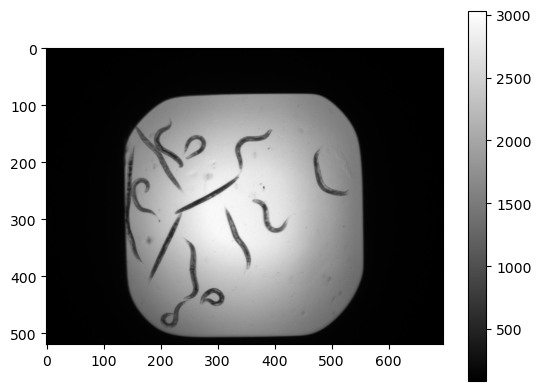

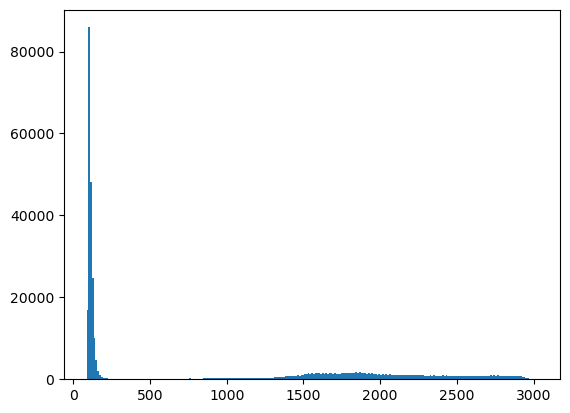

In [75]:
plt.imshow(l_img[0], cmap="gray")
plt.colorbar()
plt.show()

plt.hist(l_img[0].flatten(), bins = 255)
plt.show()

### Preprocessing des images

#### Dilatation des histogrammes

On ramène les valeurs d'intensité des pixels entre 0 et 255 par dilatation des histogrammes

In [76]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

In [77]:
l_img_stretched = []

for img in l_img :
    l_img_stretched.append(stretch(img).astype(int).copy())

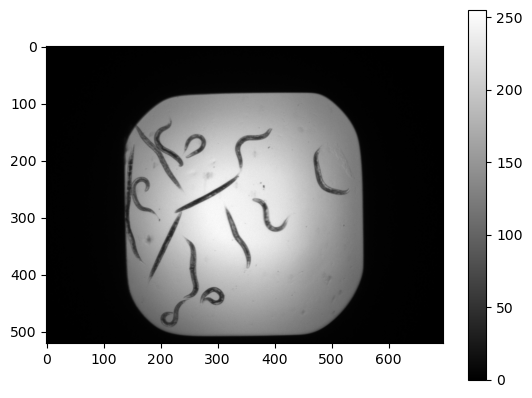

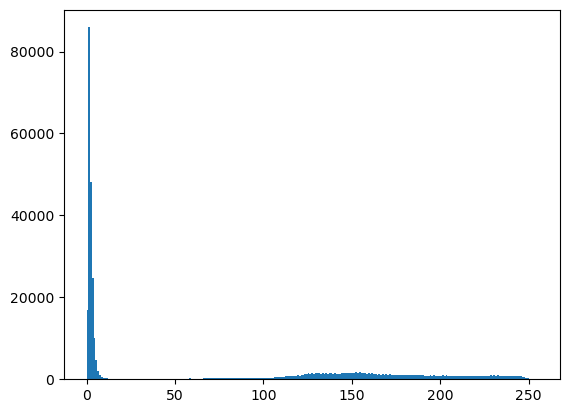

In [78]:
plt.imshow(l_img_stretched[0], cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(l_img_stretched[0].flatten(), bins = 255)
plt.show()

### Seuillage

Pour augmenter, uniformiser le contraste et même commencer à isoler les nématodes, on cherche à déterminer un seuil d'intensité 

#### Seuil global

Aucun seuil global n'a pas pu être utilisé à cause des grandes variation de luminosité du fond dans les fenêtres d'intéret : il y a un important effet de vignetage.

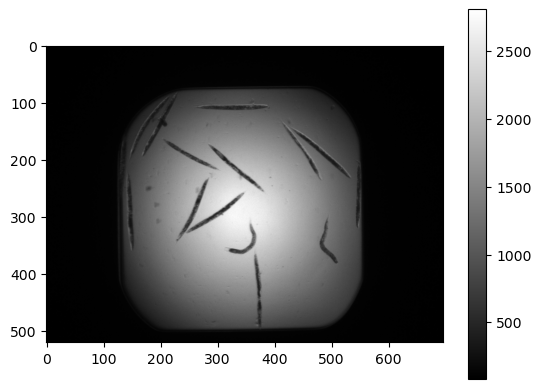

In [137]:
plt.imshow(l_img[13], cmap="gray")
plt.colorbar()
plt.show()

#### Seuil local

Un seuil local dans une fenêtre de 51 bloques est alors appliqué à l'aide de la fonction filters.threshold_local

In [79]:
l_img_local_thresholded = []

block_size = 51
for img in l_img_stretched:
    local_thresh = filters.threshold_local(img, block_size, offset=10)
    l_img_local_thresholded.append(img < local_thresh)


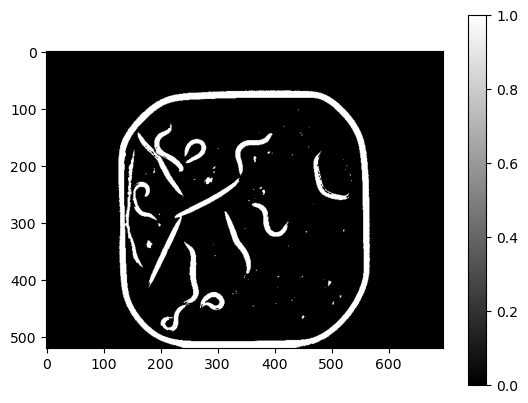

In [80]:
plt.imshow(l_img_local_thresholded[0], cmap="gray")
plt.colorbar()
plt.show()

### Supression du contour du récipiant

On constate que l'étape de seuillage fait ressortir les contours des récipiants dans chaque image.  
Pour les supprimer, ces contours sont isolés à partir des images de départ, puis dilaté à l'aide d'un kernel de 21 par 21 pixels.

In [81]:
l_window = []

window_threshold = 8

for img in l_img_stretched:
    window = img>window_threshold
    l_window.append(window)

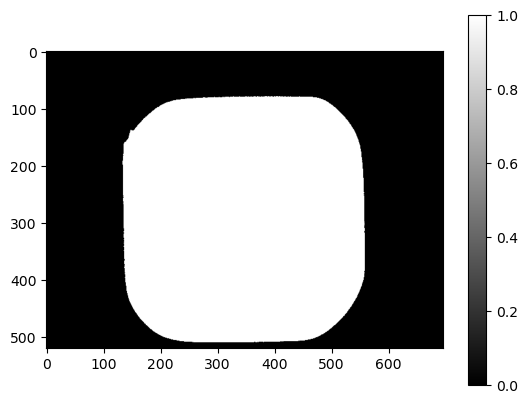

In [82]:
plt.imshow(l_window[0], cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [83]:
l_window_countour = []

for window in  l_window :
    l_window_countour.append(stretch(filters.sobel(window))>30)


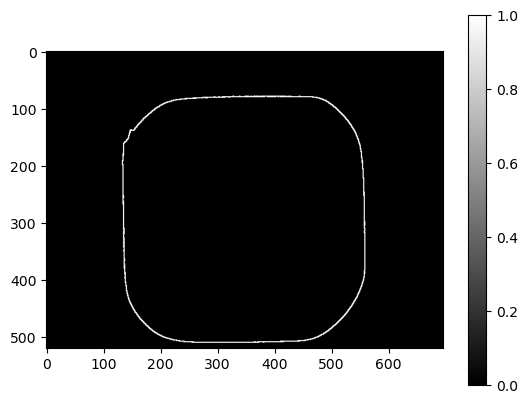

In [84]:
plt.imshow(l_window_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [85]:
l_wide_window_negative_countour = []

width = 21

for negative_countour in l_window_countour:
    l_wide_window_negative_countour.append(signal.convolve2d(negative_countour,np.ones((width,width)),mode='same')==0)


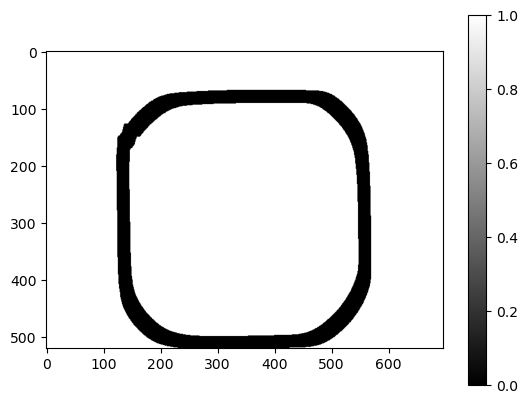

In [86]:
plt.imshow(l_wide_window_negative_countour[0], cmap="gray")
plt.colorbar()
plt.show()

Les contours obtenus sont ensuite soustraits à leurs images correspondantes obtenues après de seuillage précédent.

In [87]:
l_img_local_thresholded_nematods = []

for i,img in enumerate(l_img_local_thresholded):
    l_img_local_thresholded_nematods.append(np.multiply(np.multiply(img, l_wide_window_negative_countour[i]),l_window[i]))

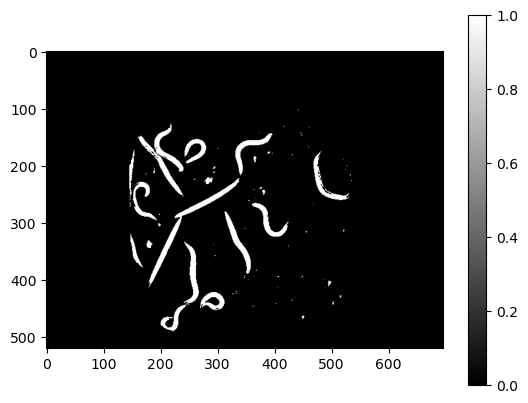

In [88]:
plt.imshow(l_img_local_thresholded_nematods[0], cmap="gray")
plt.colorbar()
plt.show()

### Opérations Morphologiques

Les images obtenues permettent une bonne segmentation des nématodes mais ceux-ci présentent parfois de larges "trous" problématiques pour les analyses futures.  
Par exemple :

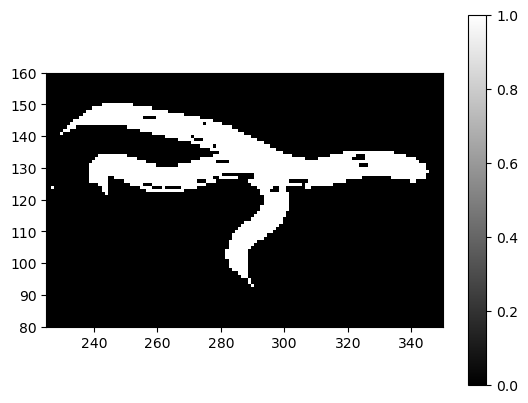

In [152]:
plt.imshow(l_img_local_thresholded_nematods[9], cmap="gray")
plt.ylim((80,160))
plt.xlim((225,350))
plt.colorbar()
plt.show()

Une succession d'érosion et de dilatation est donc réalisée pour combler ces trous.

In [89]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [90]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    dil_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                dil_img[i,j] = 1
            else :
                dil_img[i,j] = 0
    return dil_img


In [91]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

In [92]:
l_img_morph = []

for img in l_img_local_thresholded_nematods:
    l_img_morph.append(multiple_erosions_and_dilataions(img,['d','d','e','e']))

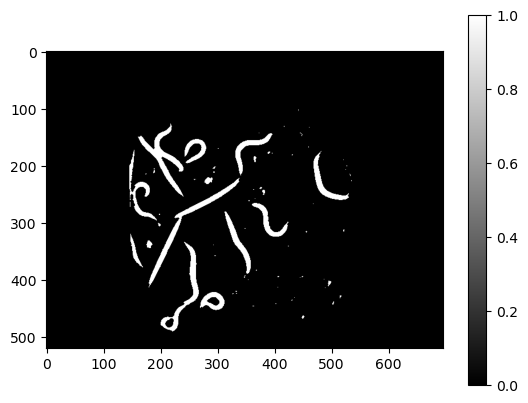

In [93]:
plt.imshow(l_img_morph[0], cmap="gray")
plt.colorbar()
plt.show()

Pour finaliser la complétion des trous sans trop dénaturer la morphologie des nématodes, notamment lorsque plusieurs d'entre eux sont supperposés, un filtre médian est appliqué.  
Ce filtre est appliqué sur une image binaire et produit donc aussi une image binaire.

In [153]:
l_img_morph_fill = []

for img in l_img_morph:
    l_img_morph_fill.append(filters.median(img))

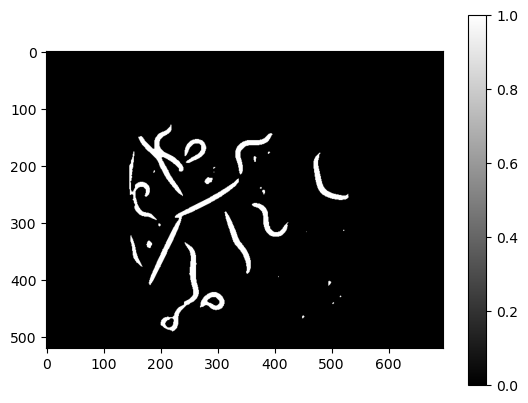

In [154]:
plt.imshow(l_img_morph_fill[0], cmap="gray")
plt.colorbar()
plt.show()

### Squelettisation 

Afin à la fois de segmenter les nématodes, de gérer les cas fréquents de supperposition et d'être en mesure d'analyser leurs caractéristiques géométriques, une oppération de "squelettisation" est appliquée via la fonction *skeletonize* du package *skimage.morphology*


In [96]:
l_skeleton = []

for img in l_img_morph_fill:
    l_skeleton.append(skeletonize(img))

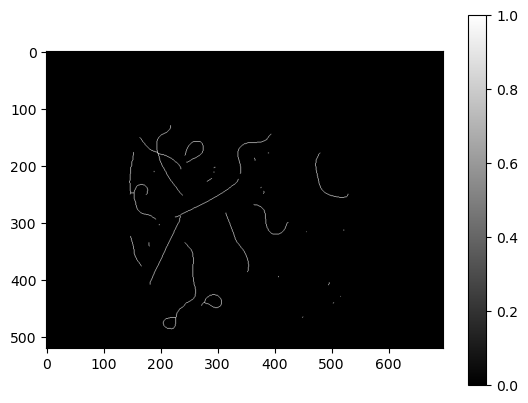

In [97]:
plt.imshow(l_skeleton[0], cmap="gray")
plt.colorbar()
plt.show()

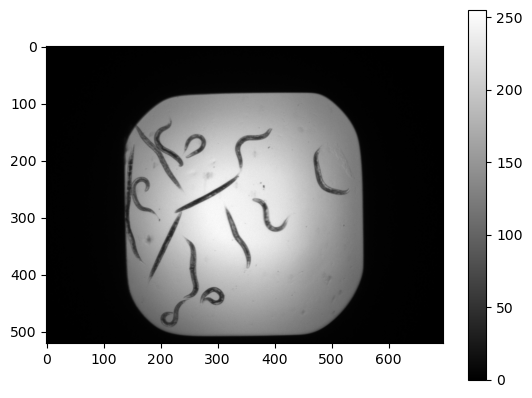

In [155]:
plt.imshow(l_img_stretched[0], cmap="gray")
plt.colorbar()
plt.show()

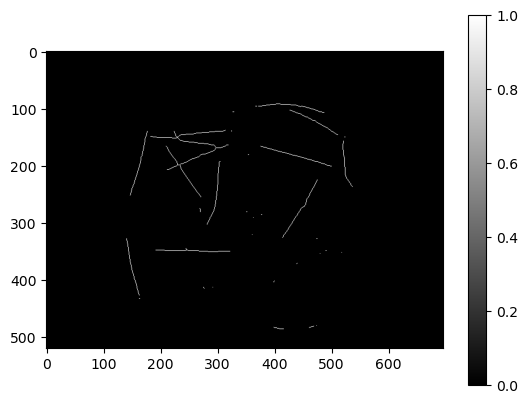

In [98]:
plt.imshow(l_skeleton[12], cmap="gray")
plt.colorbar()
plt.show()

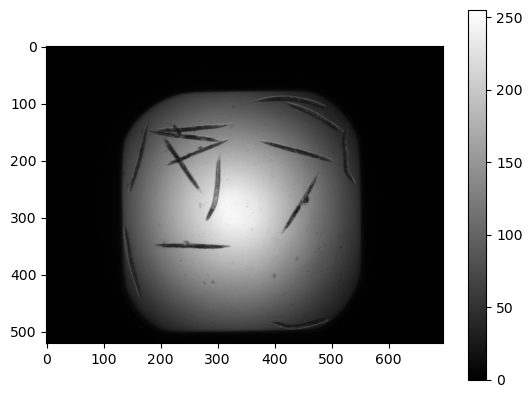

In [ ]:
plt.imshow(l_img_stretched[12], cmap="gray")
plt.colorbar()
plt.show()

### Labélisation des nématodes

Afin de pouvoir analyser les caractéristiques géométriques des nématodes, ces derniers vont être labélisés. Le principal obstacle à cette labélisation est la supperposition fréquente des nématodes.  
  
Un approche envisageable est d'analyser la topologie des squelettes obtenus pour tenter d'extraire les squelettes respectifs des némaodes supperposés.  
Un gaphe de connectivité des pixels (avec plusieurs composantes connexes) est donc construits pour chaque image. 

In [100]:
def adjacency_matrix(image):
    n = len(image)
    m = len(image[0])

    G = nx.Graph()
    for i in range (0, n):
        for j in range (0,m):
            voisins = [(i,j-1), (i, j+1), (i-1, j), (i+1, j), (i+1,j+1), (i+1, j-1), (i-1, j-1), (i-1, j+1)]
            voisins = list(map(lambda x : x if ((0 <= x[0] < n) and ( 0 <= x[1] < m)) else None , voisins))
            adjacence = list(map(lambda x : (image[i][j] and image[x[0]][x[1]]) if x is not None else None , voisins))

            for k in range(len(voisins)):
                if ((voisins[k] is not None) and (adjacence[k] == True)):
                    G.add_edge((i,j),(voisins[k][0], voisins[k][1]))
          
    return G

In [101]:
l_skeleton_graph = [adjacency_matrix(skeleton) for skeleton in l_skeleton]

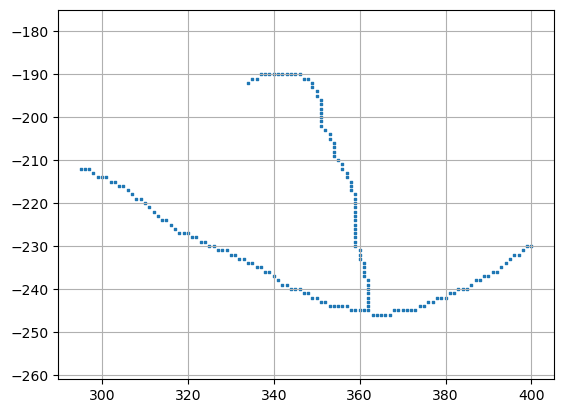

In [158]:
i = 1 # numéro de l'image
j = 11 # numéro de la composante connexe
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.grid()
plt.axis("equal")
plt.show()

## Extraction des squelettes candidats

Une fois les graphes obtenus, ils sont parcourus entre chaque extrémité (et fins de cylce) afin d'extraire tout les squelettes possibles de nématodes.

In [102]:
def all_nematods_candidates(G_connexe):
    l_end = [n for n, d in G_connexe.degree() if d == 1]
    l_end_done = []
    l_candidates = []
    for end in l_end:
        l_end_done.append(end)
        l_parcours = [end]
        current = list(G_connexe.neighbors(end))[0]

        def rec_parcours(current, l_parcours):
            if current in l_end:
                if current not in l_end_done:
                    l_parcours.append(current)
                    return l_parcours
            for neighbor in list(G_connexe.neighbors(current)):
                if neighbor in l_parcours[:-1]:
                    l_parcours.append(current)
                    return l_parcours
            
            l_parcours.append(current)
            l_neighbors = list(G_connexe.neighbors(current))
            
            return [rec_parcours(new_current, l_parcours.copy()) for new_current in l_neighbors if new_current not in l_parcours]
        
        l_candidates += rec_parcours(current, l_parcours)
    
    def flatten_l_l_tuples(object):
        res = []
        if isinstance(object, list):
            if all(isinstance(x, tuple) for x in object):
                if len(object)>0:
                    res.append(object)
            else:
                for l in object:
                    res.extend(flatten_l_l_tuples(l))
        return res

    return flatten_l_l_tuples(l_candidates)

In [103]:
l_l_skeleton_candidates = []
for i,skeleton_graph in enumerate(l_skeleton_graph):
    l_l_skeleton_candidates.append([])
    for connexe_component in list(nx.connected_components(skeleton_graph)):
        sub_skeleton_graph = skeleton_graph.subgraph(connexe_component).copy()
        l_l_skeleton_candidates[i].append(all_nematods_candidates(sub_skeleton_graph))

In [105]:
print(l_l_skeleton_candidates[1][11][0])

[(192, 334), (191, 335), (191, 336), (190, 337), (190, 338), (190, 339), (190, 340), (190, 341), (190, 342), (190, 343), (190, 344), (190, 345), (190, 346), (191, 347), (191, 348), (192, 349), (193, 349), (194, 350), (195, 350), (196, 351), (197, 351), (198, 351), (199, 351), (200, 351), (201, 351), (202, 351), (203, 352), (204, 353), (205, 353), (206, 354), (207, 354), (208, 354), (209, 354), (210, 355), (211, 356), (212, 356), (213, 357), (214, 357), (215, 358), (216, 358), (217, 358), (218, 359), (219, 359), (220, 359), (221, 359), (222, 359), (223, 359), (224, 359), (225, 359), (226, 359), (227, 359), (228, 359), (229, 359), (230, 359), (231, 360), (232, 360), (233, 360), (234, 361), (235, 361), (236, 361), (237, 361), (238, 362), (239, 362), (240, 362), (241, 362), (242, 362), (243, 362), (244, 362), (245, 362), (246, 363), (246, 364), (246, 365), (246, 366), (246, 367), (245, 368), (245, 369), (245, 370), (245, 371), (245, 372), (245, 373), (244, 374), (244, 375), (243, 376), (24

l_l_skeleton_candidates est donc une liste (pour chaque image) de listes (pour chque composante connexe) de squelettes possibles de nématodes.

### Trie des candidats

Une fois les candidats obtenus, il s'agit de les trier afin d'identifier les vrais sequelettes de nématodes. 

#### Méthodes non concluantes

In [112]:
def direction(l_points):
    pts = np.array(l_points)
    x = pts[:, 0]
    y = pts[:, 1]

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return np.array([1.0, a])


def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)

    cosang = np.dot(v1, v2)
    cosang = max(min(cosang, 1), -1)

    return np.degrees(np.arccos(cosang))


def angle_k_regression(candidate, i, k):
    if i < k or i >= len(candidate) - k:
        return None

    before = candidate[i-k:i]     
    after  = candidate[i+1:i+1+k]  

    u = direction(before)
    v = direction(after)

    return angle_between(u, v)

def score_angle(candidate, i, k = 10):
    angle = angle_k_regression(candidate, i, k)
    if angle is None:
        return None
    if angle<=90:
        return angle
    else :
        return 180-angle


In [113]:
i = 4 # numéro de l'image
j = 0 # numéro du candidat

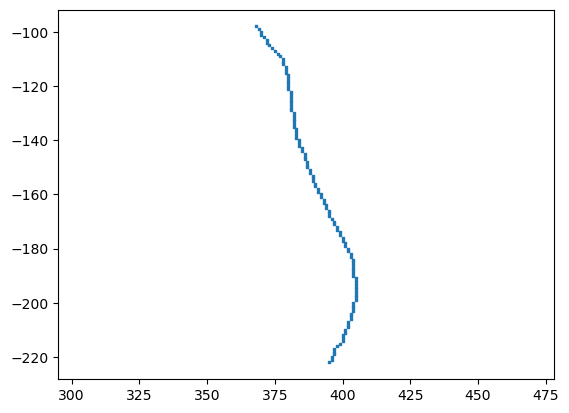

In [114]:
c = l_l_skeleton_candidates[i][j][0]
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

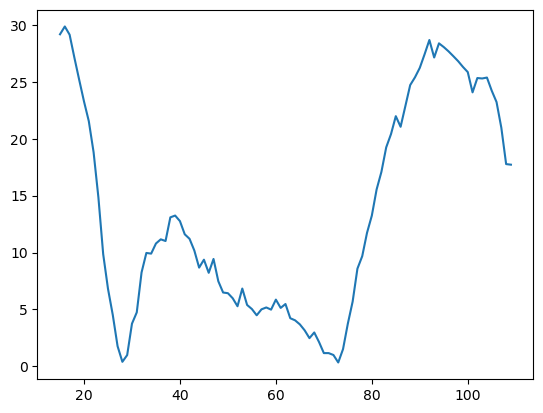

In [115]:
plt.plot([score_angle(l_l_skeleton_candidates[i][j][0],num, k= 15) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.show()

marche pas car skeleton pas smooth

In [116]:
from scipy.interpolate import CubicSpline
import numpy as np

def courbure_spline_param(points):
    pts = np.array(points)
    n = len(pts)

    # paramètre t = 0..1
    t = np.linspace(0, 1, n)

    Sx = CubicSpline(t, pts[:,0])
    Sy = CubicSpline(t, pts[:,1])

    def kappa(ti):
        dx = Sx.derivative(1)(ti)
        dy = Sy.derivative(1)(ti)
        d2x = Sx.derivative(2)(ti)
        d2y = Sy.derivative(2)(ti)
        num = abs(dx*d2y - dy*d2x)
        den = (dx*dx + dy*dy)**1.5
        return num / den

    return kappa, t

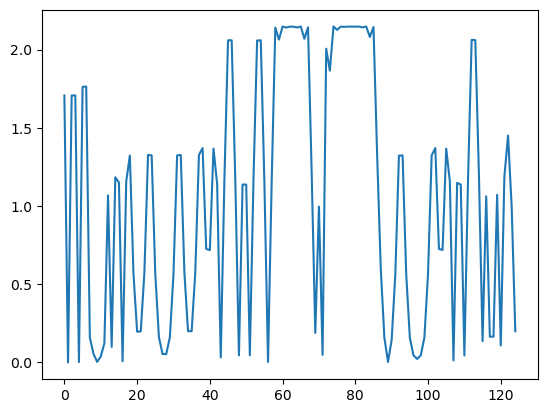

In [117]:
kappa, t = courbure_spline_param(l_l_skeleton_candidates[i][j][0])
plt.plot([kappa(i) for i in t])
plt.show()

In [118]:
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res)


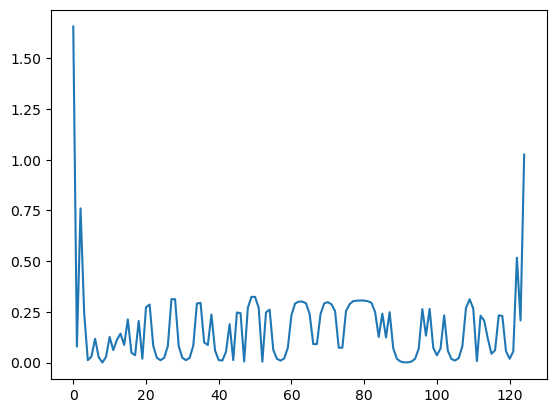

In [119]:
kappa, t = courbure_spline_param(smooth_points(l_l_skeleton_candidates[i][j][0]))
plt.plot([kappa(i) for i in t])
plt.show()

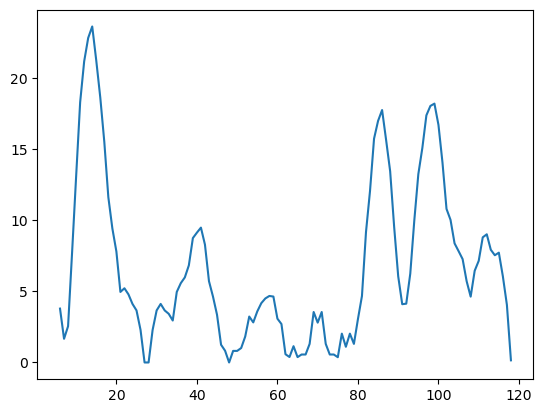

In [120]:
plt.plot([score_angle(smooth_points(l_l_skeleton_candidates[i][j][0]),num, k= 6) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.show()

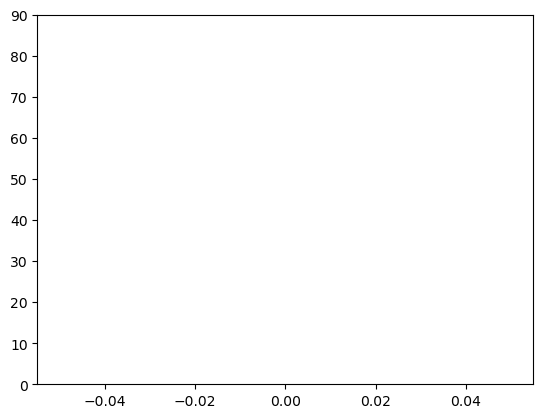

In [121]:
plt.plot([score_angle(smooth_points(l_l_skeleton_candidates[1][0][0]),num, k= 3) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.ylim((0,90))
plt.show()

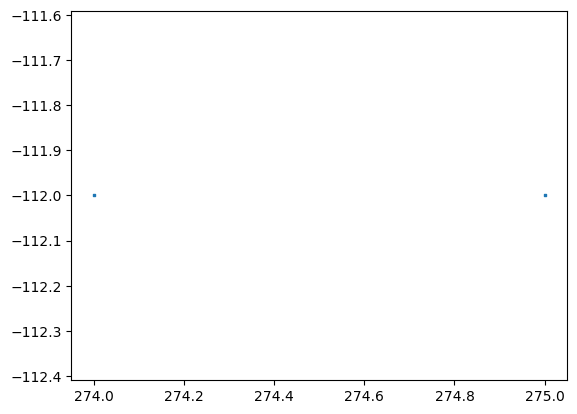

In [122]:
c = l_l_skeleton_candidates[1][0][0]
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

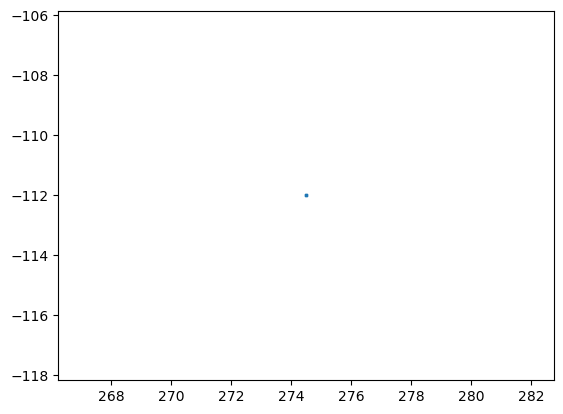

In [123]:
c = smooth_points(l_l_skeleton_candidates[1][0][0])
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

In [124]:
def direction(l_points):
    pts = np.array(l_points)
    x = pts[:, 0]
    y = pts[:, 1]

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return np.array([1.0, a])


def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)

    cosang = np.dot(v1, v2)
    cosang = max(min(cosang, 1), -1)

    return np.degrees(np.arccos(cosang))


def angle_k_regression(nodes, i, k):
    if i < k or i >= len(nodes) - k:
        return None

    before = nodes[i-k:i]     
    after  = nodes[i+1:i+1+k]  

    u = direction(before)
    v = direction(after)

    return angle_between(u, v)

def score_angle(nodes, i, k):
    angle = angle_k_regression(nodes, i, k)
    if angle is None:
        return None
    if angle<=90:
        return angle
    else :
        return 180-angle
    
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res)

def all_score_angle(candidate, k = 10):
    nodes = smooth_points(list(c))
    l_score_angle = []
    for i in range(k,len(candidate)-k):
        l_score_angle.append(score_angle(candidate, i, k))
    return l_score_angle


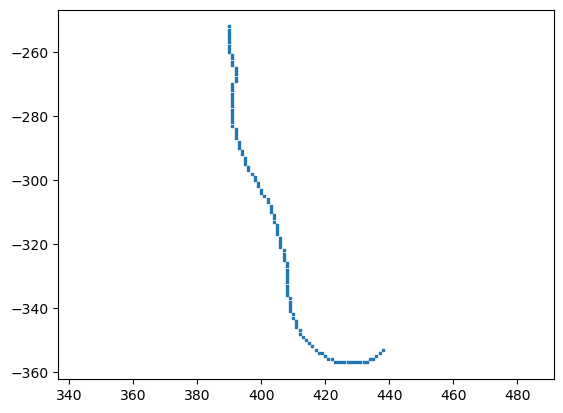

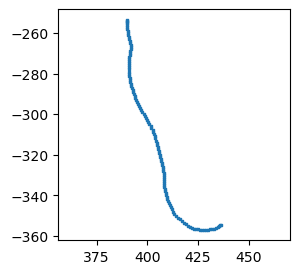

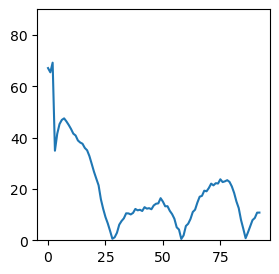

In [125]:
i = 4
j = 10
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

for c in (l_l_skeleton_candidates[i][j][:15]) :
    nodes = smooth_points(list(c))
    x_coords = [n[1] for n in nodes]
    y_coords = [-n[0] for n in nodes]
    plt.figure(figsize=(3,3))
    plt.scatter(x_coords, y_coords, s=1, marker='s')
    plt.axis("equal")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.plot(all_score_angle(c, k= 15))
    plt.ylim((0,90))
    plt.show()

#### Seuil sur la longueur des squelettes

Afin d'éliminer le bruit résiduel, les longueurs des squelettes des composantes connexes avec un seul candidat (ie exactement deux extrémités) sont représentées sous forme d'histogramme

In [ ]:
l_one_nematod_in_one_connexe_part = []

for i in range(len(l_l_skeleton_candidates)):
    for j in range(len(l_l_skeleton_candidates[i])):
        if len(l_l_skeleton_candidates[i][j]) == 1:
            """nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
            x_coords = [n[1] for n in nodes]
            y_coords = [-n[0] for n in nodes]
            plt.figure(figsize=(3,3))
            plt.scatter(x_coords, y_coords, s=1, marker='s')
            plt.axis("equal")
            plt.show()"""
            l_one_nematod_in_one_connexe_part.append(len(l_l_skeleton_candidates[i][j][0]))

print(len(l_one_nematod_in_one_connexe_part))

554


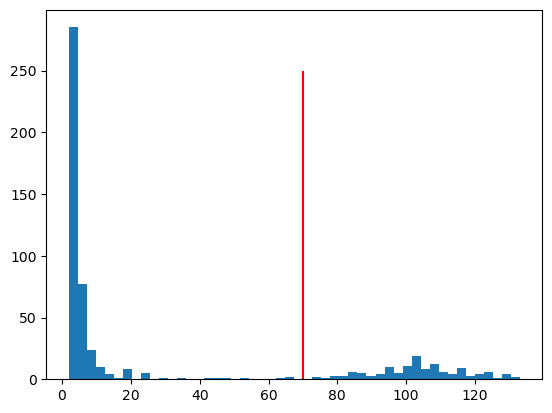

In [163]:
plt.hist(l_one_nematod_in_one_connexe_part, bins = 50)
plt.vlines(70,0,250, colors='red')
plt.show()

Deux groupes de squelettes sont identifiés : le seuil d'une longueur de 70 pixels est choisi pour faire la distinction en le bruit ou les faux candidats et les réel squelettes de nématodes. 

#### Méthode basée sur la courbure

Cette approche permet d'éliminer les squelettes candidats présentant des profils de coubures aberrants.

Les profils de courbure sont calculés comme l'angle entre deux droites obtenue par régression linéaire sur k points. 

In [160]:
def courbure(points, k=10):
    points = np.array(points)
    n = len(points)
    courbures = []

    for i in range(k, n - k):
        p_prev = points[i - k]
        p = points[i]
        p_next = points[i + k]

        u = p - p_prev
        v = p_next - p

        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        if norm_u == 0 or norm_v == 0:
            courbures.append(0)
            continue

        cos_theta = np.dot(u, v) / (norm_u * norm_v)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta)

        l = (norm_u + norm_v) / 2
        kappa = theta / l

        courbures.append(kappa)

    return np.array(courbures)

Cette approche nécessite cependant un prétraitement des coordonnées des pixels car elle est très sensible à la résolution spatiale.  
Une fonction d'adoucissement des squelettes candidats est donc appliqué avant le calcul des profils de courbure.

In [161]:
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res)

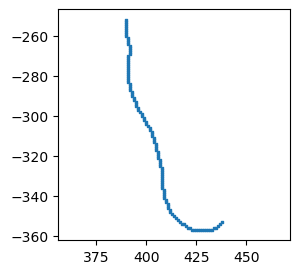

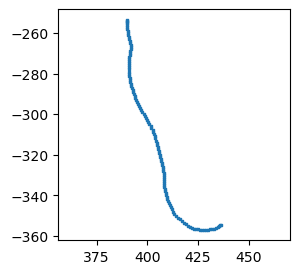

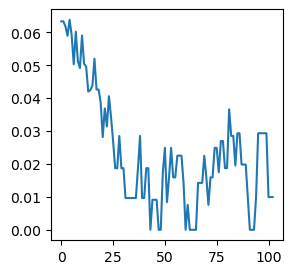

0.023843685572045067


In [162]:
i=4
j=10
nodes = list(l_l_skeleton_candidates[i][j][0])
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]
plt.figure(figsize=(3,3))
plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]
plt.figure(figsize=(3,3))
plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

plt.figure(figsize=(3,3))
plt.plot(courbure(l_l_skeleton_candidates[i][j][0]))
plt.show()
print(np.mean(courbure(l_l_skeleton_candidates[i][j][0])))

In [130]:
def choose_candidate(l_l_skeleton_candidates):
    l_l_nematods = []
    for i in range(len(l_l_skeleton_candidates)):
        l_l_nematods.append([])
        for j in range(len(l_l_skeleton_candidates[i])):
            if len(l_l_skeleton_candidates[i][j]) == 1: # partie connexe avec une seule possibilité : un bruit ou un nematode unique
                if len(l_l_skeleton_candidates[i][j][0]) > 60 :
                    l_l_nematods[i].append(l_l_skeleton_candidates[i][j][0])
            else :
                # complicated part
                
                a=1
    return l_l_nematods

In [131]:
l_l_nematods = choose_candidate(l_l_skeleton_candidates)

# Calcul des caractéristiques géométriques

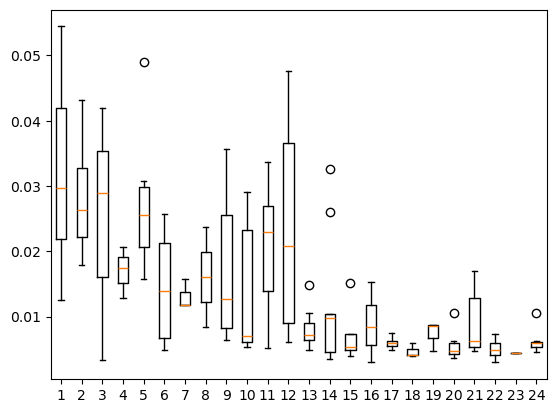

In [132]:
plt.boxplot([[np.mean(courbure(nematod)) for nematod in l_l_nematods[i]] for i in range(len(l_l_nematods))])
plt.show()

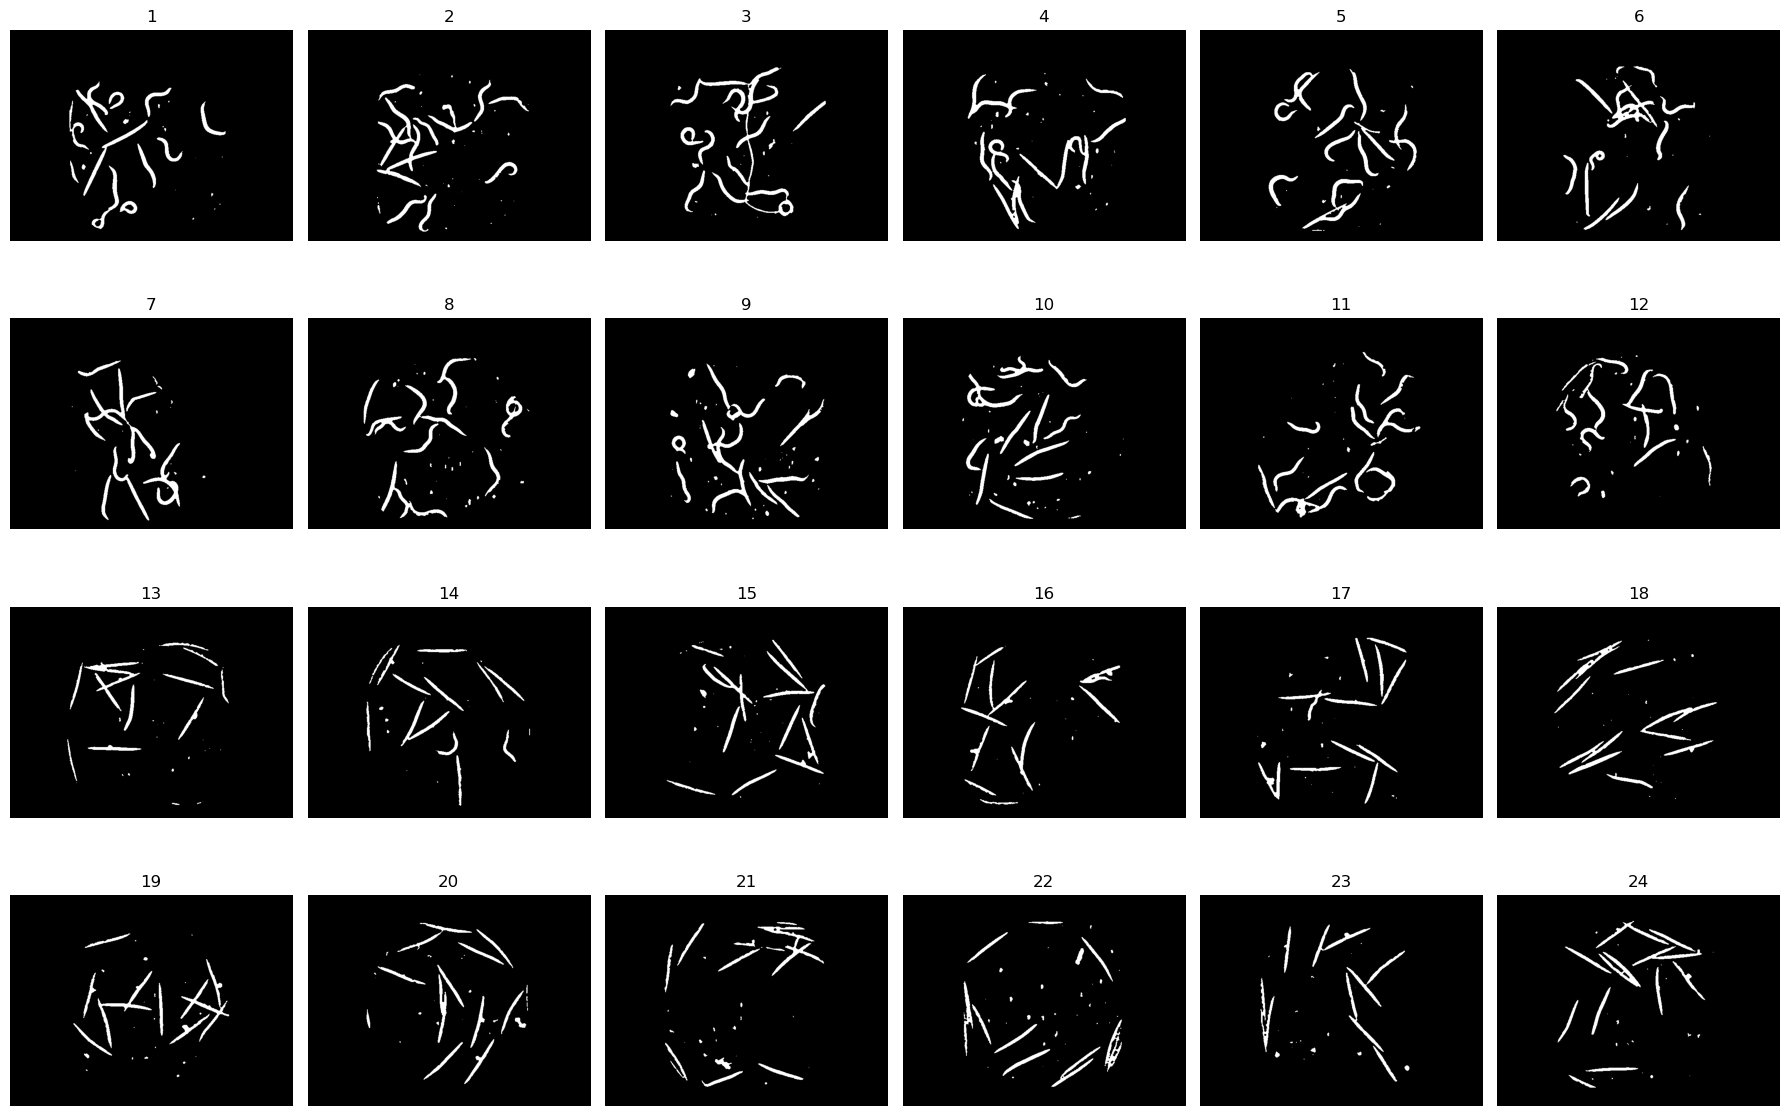

In [133]:
n = len(l_img_morph_fill)
cols = 6       
rows = 4
plt.figure(figsize=(3*cols, 3*rows))
for i, img in enumerate(l_img_morph_fill):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(i+1)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Analyse des résultats

# Conclusion